# Self-Driving Car Engineer Nanodegree

## Deep Learning



---
## Step 1: Import all the dependencies

In [183]:
import pickle
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## Step 2: Load The Data

In [184]:
TRAINING_FILE = 'train.p'
VALIDATION_FILE = 'valid.p'
TESTING_FILE = 'test.p'

with open(TRAINING_FILE, mode='rb') as f:
    train = pickle.load(f)
with open(VALIDATION_FILE, mode='rb') as f:
    valid = pickle.load(f)
with open(TESTING_FILE, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 3: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [185]:
def get_description():
    """
    Prints the description of the dataset.
    """
    n_train = len(X_train)
    n_test = len(X_test)

    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    image_shape = np.shape(image)

    n_classes = len(y_train) + len(y_test)

    print("Number of training examples =", n_train)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

In [186]:
get_description()

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 47429


### Step 3.1: Visualization of the dataset

In [187]:
def show_image(data):
    """
    Displays a random images from the dataset with the class label.
    """
    num = 1
    index = random.sample(range(len(data)), 4)

    fig = plt.figure()

    for n in index:
        fig.add_subplot(2, 2, num)
        image = data[n].squeeze()
        plt.imshow(image)
        plt.title("Class Label {}".format(n))
        num += 1
        
    fig.tight_layout()
    plt.show()
    %matplotlib inline

#### Step 3.1.1 Training dataset

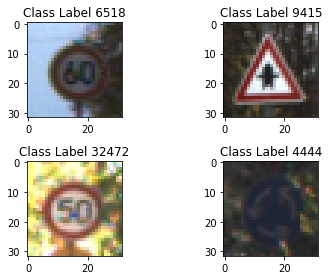

In [188]:
show_image(X_train)

#### Step 3.1.2 Validation dataset

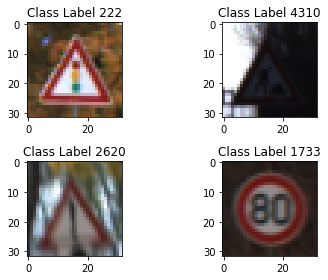

In [189]:
show_image(X_validation)

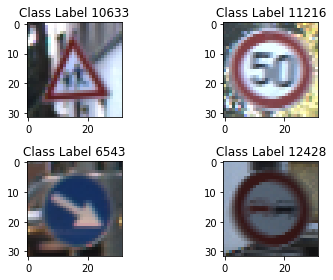

In [190]:
show_image(X_test)

----

## Step 4: Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Step 4.1: Data preprocessor

#### Step 4.1.2: Normalise data

Using the formula:

\begin{equation*}
y_i=\frac{x_i-\mu(x)}{\max(x)-\min(x)}
\end{equation*}

In [191]:
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_validation = (X_validation - X_validation.mean()) / (np.max(X_validation) - np.min(X_validation))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

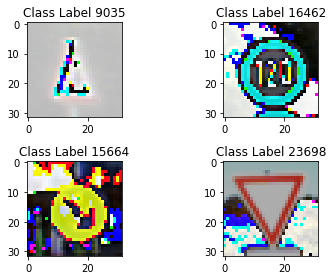

In [192]:
show_image(X_train)

### Step 4.2: Model Architecture

#### Step 4.2.1: Training

In [206]:
EPOCHS = 100
BATCH_SIZE = 100
RATE = 0.001
MU = 0
SIGMA = 0.1
PADDING = 'VALID'

In [207]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

In [208]:
def lenet(x_input):
    """
    CNN for the dataset.
    Parameters
    ----------
    x_input

    Returns
    -------
    tensor
    """
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=MU, stddev=SIGMA))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x_input, conv1_w, strides=[1, 1, 1, 1], padding=PADDING) + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=PADDING)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=MU, stddev=SIGMA))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding=PADDING) + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=MU, stddev=SIGMA))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b

    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=MU, stddev=SIGMA))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b

    # Activation.
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=MU, stddev=SIGMA))
    fc3_b = tf.Variable(tf.zeros(43))
    _logits = tf.matmul(fc2, fc3_w) + fc3_b

    return _logits

In [209]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [210]:
# Get the model
logits = lenet(x)

# loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=RATE)
training_operation = optimizer.minimize(loss_operation)

# Check if correctly predicted.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [220]:
def evaluate(X_data, y_data):
    """
    Evaluates the total accuracy for the given inputs.
    Parameters
    ----------
    X_data
    y_data

    Returns
    -------
    numpy.float64

    """
    num_examples = len(X_data)
    total_accuracy = 0
    with sess.as_default():
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [223]:
# Running the training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
num_examples = len(X_train)
validation_accuracy = 0

print("Training...")
print()
for i in range(EPOCHS):
    if validation_accuracy >= 0.95:
        break
    _X_train, _y_train = shuffle(X_train, y_train)
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = _X_train[offset:end], _y_train[offset:end]
        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
    
    
    validation_accuracy = evaluate(8, y_validation)
    test_accuracy = evaluate(X_test, y_test)
    print("EPOCH {} ...".format(i + 1))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
saver.save(sess, './lenet')
print("Model saved")

print()
print()

print("Batch size: ", BATCH_SIZE)
print("Number of epochs: ", EPOCHS)
print("Learning rate: ", RATE)
print("Mean for Truncated Normal: ", MU)
print("Standard devation for Truncated Normal: ", SIGMA)
print("Convolution type: ", PADDING)

Training...

EPOCH 1 ...
Test Accuracy = 0.768
Validation Accuracy = 0.790
EPOCH 2 ...
Test Accuracy = 0.859
Validation Accuracy = 0.881
EPOCH 3 ...
Test Accuracy = 0.879
Validation Accuracy = 0.887
EPOCH 4 ...
Test Accuracy = 0.892
Validation Accuracy = 0.904
EPOCH 5 ...
Test Accuracy = 0.896
Validation Accuracy = 0.908
EPOCH 6 ...
Test Accuracy = 0.896
Validation Accuracy = 0.916
EPOCH 7 ...
Test Accuracy = 0.904
Validation Accuracy = 0.914
EPOCH 8 ...
Test Accuracy = 0.895
Validation Accuracy = 0.900
EPOCH 9 ...
Test Accuracy = 0.903
Validation Accuracy = 0.917
EPOCH 10 ...
Test Accuracy = 0.914
Validation Accuracy = 0.921
EPOCH 11 ...
Test Accuracy = 0.895
Validation Accuracy = 0.912
EPOCH 12 ...
Test Accuracy = 0.905
Validation Accuracy = 0.927
EPOCH 13 ...
Test Accuracy = 0.884
Validation Accuracy = 0.911
EPOCH 14 ...
Test Accuracy = 0.920
Validation Accuracy = 0.934
EPOCH 15 ...
Test Accuracy = 0.914
Validation Accuracy = 0.932
EPOCH 16 ...
Test Accuracy = 0.915
Validation Accur

## Step 6: Testing on New Data

In [224]:
def load_image(file_name):
    """
    Loads and converts the image into an NumPy array.
    """
    try:
        image = mpimg.imread(file_name)  # Reading a image file.
        print("Image type: {}, and it's shape: {}".format(type(image), image.shape))
    except FileNotFoundError as e:
        print(e)
        sys.exit(1)
    return image


def show_image_test(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

### Step 6.1 Images Used

#### Step 6.1.1: Data-1

Image type: <class 'numpy.ndarray'>, and it's shape: (425, 425, 3)


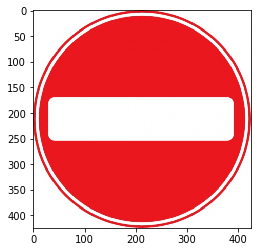

In [225]:
im1 = load_image('images/no_entry.jpg')
show_image_test(im1)

#### Step 6.1.2: Data-2

Image type: <class 'numpy.ndarray'>, and it's shape: (225, 300, 3)


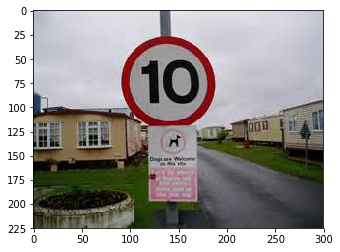

In [226]:
im2 = load_image('images/10.jpg')
show_image_test(im2)

#### Step 6.1.3: Data-3

Image type: <class 'numpy.ndarray'>, and it's shape: (200, 300, 3)


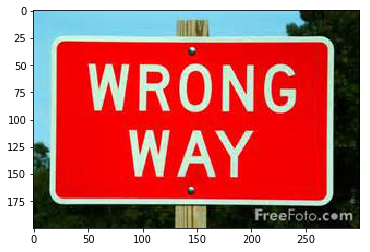

In [227]:
im3 = load_image('images/wrong_way.jpg')
show_image_test(im3)

#### Step 6.1.4: Data-4

Image type: <class 'numpy.ndarray'>, and it's shape: (225, 300, 3)


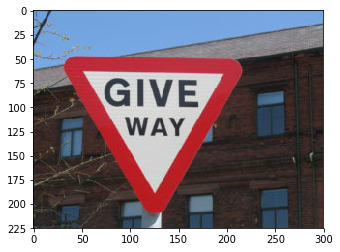

In [228]:
im4 = load_image('images/give_way_sign.jpg')
show_image_test(im4)

#### Step 6.1.5: Data-5

Image type: <class 'numpy.ndarray'>, and it's shape: (493, 876, 3)


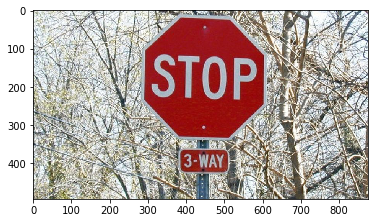

In [229]:
im5 = load_image('images/stop.jpg')
show_image_test(im5)

Resizing the images into square

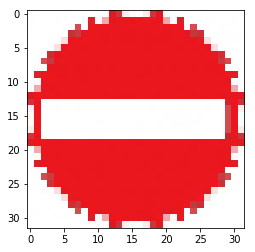

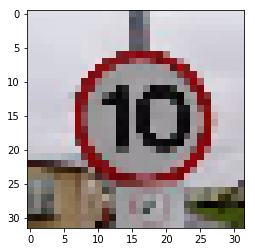

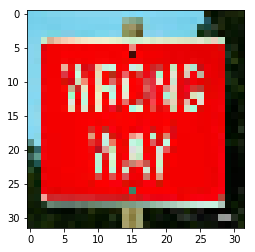

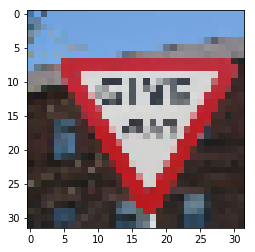

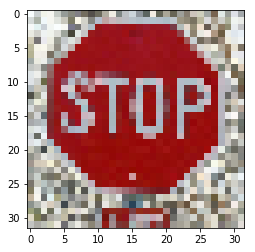

In [230]:
im1_scaled = cv2.resize(im1, (32, 32))
show_image_test(im1_scaled)

im2_cropped = im2[0:150, 60:210, :]
im2_scaled = cv2.resize(im2_cropped, (32, 32))
show_image_test(im2_scaled)

im3_scaled = cv2.resize(im3, (32, 32))
show_image_test(im3_scaled)

im4_cropped = im4[:, 0:225, :]
im4_scaled = cv2.resize(im4_cropped, (32, 32))
show_image_test(im4_scaled)

im5_cropped = im5[0:400, 250:650, :]
im5_scaled = cv2.resize(im5_cropped, (32, 32))
show_image_test(im5_scaled)



### Step 6.2: Prediction

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [339]:
def show_pred_image(index):
    plt.imshow(X_train[index])

In [410]:
def prediction(data):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        classification = sess.run(tf.argmax(logits, 1), feed_dict={x: [data]})
#         classification = sess.run(accuracy_operation, feed_dict={x: data, y: 1})
        print(classification)
    return classification

[17]


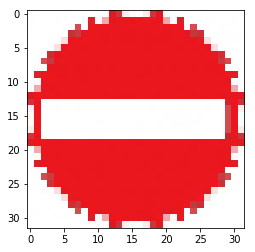

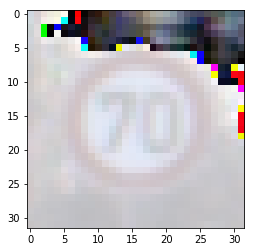

In [411]:
pred = prediction(im1_scaled)
show_image_test(im1_scaled)
show_pred_image(pred[0])

[4]


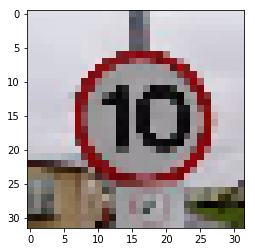

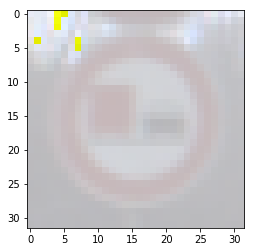

In [412]:
pred = prediction(im2_scaled)
show_image_test(im2_scaled)
show_pred_image(pred[0])

[29]


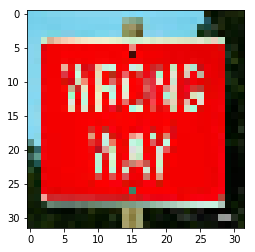

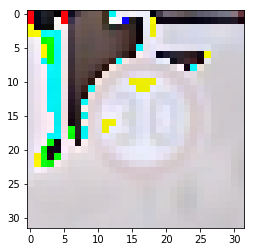

In [358]:
pred = prediction(im3_scaled)
show_image_test(im3_scaled)
show_pred_image(pred[0])

[13]


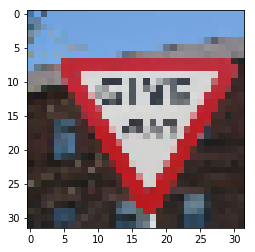

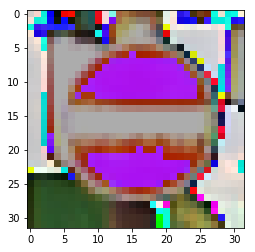

In [359]:
pred = prediction(im4_scaled)
show_image_test(im4_scaled)
show_pred_image(pred[0])

[14]


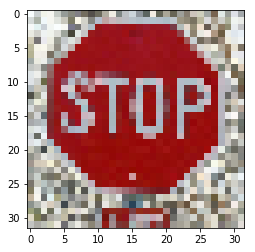

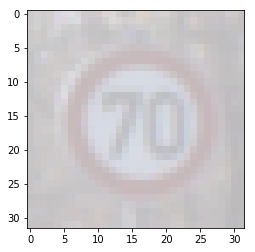

In [360]:
pred = prediction(im5_scaled)
show_image_test(im5_scaled)
show_pred_image(pred[0])

### Step 6.3: Top 5 Softmax Probabilities

In [431]:
def get_softmax(img):
    softmax = tf.nn.softmax(logits=logits)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        output = sess.run(softmax, feed_dict={x: [img]})
        out = sess.run(tf.nn.top_k(tf.constant(output), k=5))
        print(out)

In [432]:
get_softmax(im1_scaled)
get_softmax(im2_scaled)
get_softmax(im3_scaled)
get_softmax(im4_scaled)
get_softmax(im5_scaled)

TopKV2(values=array([[  1.00000000e+00,   1.06944298e-09,   3.91807761e-14,
          1.14331450e-20,   1.56463792e-23]], dtype=float32), indices=array([[33, 14, 40, 34, 29]]))
TopKV2(values=array([[  9.97897863e-01,   2.01232568e-03,   8.88976865e-05,
          8.02834847e-07,   6.03595680e-08]], dtype=float32), indices=array([[ 9, 14, 11,  0, 39]]))
TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[16,  0,  1,  2,  3]]))
TopKV2(values=array([[  1.00000000e+00,   3.21507927e-27,   4.67273110e-31,
          1.23757916e-39,   8.92627122e-42]], dtype=float32), indices=array([[32, 33, 29,  0, 15]]))
TopKV2(values=array([[  9.99916434e-01,   8.35281317e-05,   1.95860639e-09,
          4.34062508e-14,   1.25202036e-15]], dtype=float32), indices=array([[31, 24, 26, 13,  3]]))


---

## Step 7: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 